# Variational Autoencoder (VAE) for Anime Portrait Generation
- **Images**: Anime-style portrait images **(64x64, RGB)**
- **Classes**: Various anime characters, but for VAE we **ignore labels**
- **Shape**: `(batch_size, 3, 64, 64)` → 3 RGB channels



## 1️⃣ Dataset Class

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Custom Dataset class for Hugging Face dataset
class AnimeDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        elif not isinstance(image, Image.Image):
            image = Image.open(image).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, 0  # Return dummy label for compatibility

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64
    transforms.ToTensor(),        # Convert to tensor [0,1]
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

In [4]:
hf_dataset = load_dataset("quindici1515/Anime_style_portrait_dataset", split="train")


In [5]:
train_dataset = AnimeDataset(hf_dataset, transform=transform)


In [11]:
batch_size =  256 # Reduced batch size for larger images
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Check dataset size
print(f"Training samples: {len(train_dataset)}")

Training samples: 4000


### Let's display some images

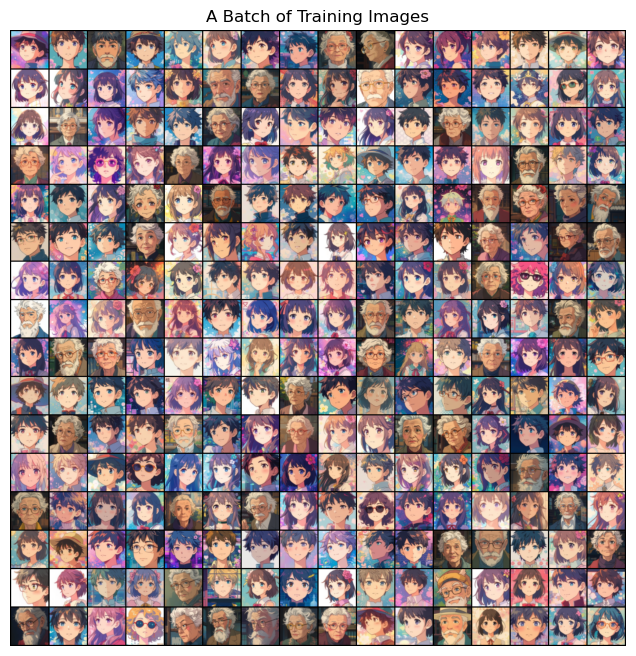

In [12]:
import torchvision

# 确保 train_loader 已经定义
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# 1. 从 train_loader 获取一个批次的数据
# iter(train_loader) 会创建一个迭代器
# next() 会从迭代器中获取下一个项目（也就是第一个批次）
try:
    images, _ = next(iter(train_loader)) # 我们不需要标签，所以用 _ 忽略
except RuntimeError as e:
    print("捕获到 DataLoader 错误。正在尝试以 num_workers=0 的模式重新加载...")
    print(f"原始错误: {e}")
    # 临时创建一个 num_workers=0 的 loader 来调试和显示
    temp_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    images, _ = next(iter(temp_loader))


# 2. 使用 torchvision.utils.make_grid 创建一个图像网格
# make_grid 是一个非常方便的工具，它可以将一个批次的图像排列成网格
# normalize=True 会自动将图像的 [-1, 1] 范围转换回 [0, 1]
grid = torchvision.utils.make_grid(images, nrow=16, normalize=True, padding=2)

# 3. 显示图像
# 我们需要将张量从 (C, H, W) 转换为 (H, W, C) 以便 matplotlib 显示
grid_np = grid.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(12, 8))
plt.imshow(grid_np)
plt.axis('off') # 关闭坐标轴
plt.title('A Batch of Training Images')
plt.show()

## 2️⃣ Model Class

# **📌 Variational Autoencoder (VAE) Model**
A **Variational Autoencoder (VAE)** is a generative model that learns to **encode data into a probabilistic latent space** and **decode it back to reconstruct the original data**.

## **🔹 Key Differences from Standard Autoencoder**
1️⃣ **Probabilistic Encoding**
   - Instead of deterministic encoding, VAE learns **mean (μ) and log-variance (σ²)** of latent distribution
   - Uses **reparameterization trick** to sample from learned distribution

2️⃣ **KL Divergence Loss**
   - Regularizes latent space to follow standard normal distribution
   - Enables smooth interpolation and generation

3️⃣ **Better Generation**
   - Can generate new samples by sampling from prior distribution
   - More structured and meaningful latent space

![VAE Architecture](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*r1R0cxCnErWgE0P4Q-hI0Q.jpeg)

## **📌 Expected Input & Output Shapes**
- **Input:** `(batch_size, 3, 64, 64)`
- **Encoded μ, σ:** `(batch_size, latent_dim)`
- **Decoded Output:** `(batch_size, 3, 64, 64)`

In [13]:
# Helper: 定义一个残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 如果输入输出维度或步长不同，需要一个shortcut连接来匹配维度
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity # 核心：残差连接
        out = self.relu(out)
        return out

In [25]:
class UpgradedVAE(nn.Module):
    def __init__(self, latent_dim=512): # 增加了 latent_dim
        super(UpgradedVAE, self).__init__()
        
        # ------------------
        # 1. 加强版编码器 (Encoder)
        # ------------------
        self.encoder = nn.Sequential(
            # Initial convolution
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # -> 64x32x32
            nn.ReLU(),
            # Residual Blocks
            ResidualBlock(64, 128, stride=2), # -> 128x16x16
            ResidualBlock(128, 256, stride=2), # -> 256x8x8
            ResidualBlock(256, 512, stride=2), # -> 512x4x4
            nn.Flatten()
        )
        
        encoder_output_size = 512 * 4 * 4
        self.fc_mu = nn.Linear(encoder_output_size, latent_dim)
        self.fc_log_var = nn.Linear(encoder_output_size, latent_dim)

        # ------------------
        # 2. 加强版解码器 (Decoder)
        # ------------------
        self.decoder_fc = nn.Linear(latent_dim, encoder_output_size)
        
        self.decoder = nn.Sequential(
            # Reshape to 512x4x4
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), # -> 256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # -> 64x32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1), # -> 3x64x64
            nn.Tanh()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = self.fc_mu(h), self.fc_log_var(h)
        z = self.reparameterize(mu, log_var)
        recon = self.decoder_fc(z)
        recon = recon.view(-1, 512, 4, 4) # Reshape
        recon = self.decoder(recon)
        return recon, mu, log_var

# 实例化加强版模型
# upgraded_model = UpgradedVAE().to(device)
# ... 接下来是同样的训练过程

## 3️⃣ Training and Validation Loops

We will train the VAE model to learn meaningful representations of anime portraits.

1️⃣ **Forward Pass** → Encode to μ, σ, sample z, and decode

2️⃣ **Compute Loss** → Reconstruction loss + KL divergence

3️⃣ **Backward Pass** → Update model parameters

In [26]:
from tqdm import tqdm    # Shows progress bar
import torch.backends.mps  # For Apple Silicon GPU support

# 检查设备
# Check if MPS (Metal Performance Shaders) is available for Apple Silicon GPU acceleration
# MPS is a framework that allows PyTorch to utilize the GPU on Apple Silicon devices.
# If MPS is not available, we will fall back to CPU.
# This is particularly useful for users with MacBooks or Macs with M1/M2 chips.
# Note: MPS support is available in PyTorch 1.12 and later versions.
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for Apple Silicon GPU acceleration.")
else:
    device = torch.device("cpu")
    print("MPS device not found, falling back to CPU.")

# 1. 实例化加强版的 VAE 模型
latent_dim = 256 # 我们在模型定义中将 latent_dim 增加到了 256
upgraded_model = UpgradedVAE(latent_dim=latent_dim).to(device)
print(upgraded_model) # 打印模型结构，可以查看其复杂性

# 2. 定义损失函数
def loss_function(recon_x, x, mu, log_var, beta=1.0):
    """
    计算 VAE 的总损失 = 重建损失 + beta * KL 散度
    """
    # 使用均方误差 (MSE) 作为重建损失
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL 散度
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + beta * kl_div

# 3. 定义优化器
# 使用 Adam 优化器，学习率可以根据需要进行调整
optimizer = optim.Adam(upgraded_model.parameters(), lr=1e-4) # 对于更复杂的模型，稍小的学习率可能更稳定

Using MPS device for Apple Silicon GPU acceleration.
UpgradedVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): ResidualBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.

## 4️⃣ Running Training

VAE uses a combination of reconstruction loss and KL divergence loss to learn meaningful latent representations.


In [27]:
from tqdm import tqdm
import torch.nn.functional as F

def train_epoch(epoch, model, dataloader, optimizer, device):
    # 将模型设置为训练模式
    model.train()
    
    total_loss = 0
    # 使用 tqdm 创建进度条
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", unit="batch")

    for data, _ in pbar:
        # 将数据移动到指定设备 (CPU 或 GPU)
        data = data.to(device)

        # 1. 清空之前的梯度
        optimizer.zero_grad()
        
        # 2. 前向传播：通过模型获取重建图像、均值和对数方差
        recon_batch, mu, log_var = model(data)
        
        # 3. 计算损失
        loss = loss_function(recon_batch, data, mu, log_var)
        
        # 4. 反向传播：计算梯度
        loss.backward()
        
        # 累加总损失
        total_loss += loss.item()
        
        # 5. 更新模型权重
        optimizer.step()
        
        # 在进度条上显示当前批次的平均损失
        pbar.set_postfix({'Loss': loss.item() / len(data)})

    # 计算并打印当前 epoch 的平均损失
    avg_loss = total_loss / len(dataloader.dataset)
    print(f'====> Epoch {epoch} finished. Average loss: {avg_loss:.4f}')
    return avg_loss

### Plot loss and some predictions

Starting training for the UpgradedVAE model...


Epoch 1: 100%|██████████| 16/16 [01:08<00:00,  4.30s/batch, Loss=3.33e+3]


====> Epoch 1 finished. Average loss: 4734.5346


Epoch 2: 100%|██████████| 16/16 [01:09<00:00,  4.37s/batch, Loss=2.4e+3] 


====> Epoch 2 finished. Average loss: 2800.4485


Epoch 3: 100%|██████████| 16/16 [01:10<00:00,  4.39s/batch, Loss=1.83e+3]


====> Epoch 3 finished. Average loss: 2078.9604


Epoch 4: 100%|██████████| 16/16 [01:08<00:00,  4.28s/batch, Loss=1.58e+3]


====> Epoch 4 finished. Average loss: 1676.1507


Epoch 5: 100%|██████████| 16/16 [01:08<00:00,  4.26s/batch, Loss=1.37e+3]


====> Epoch 5 finished. Average loss: 1463.2919


Epoch 6: 100%|██████████| 16/16 [01:08<00:00,  4.26s/batch, Loss=1.33e+3]


====> Epoch 6 finished. Average loss: 1323.5577


Epoch 7: 100%|██████████| 16/16 [01:07<00:00,  4.25s/batch, Loss=1.19e+3]


====> Epoch 7 finished. Average loss: 1233.3434


Epoch 8: 100%|██████████| 16/16 [01:08<00:00,  4.28s/batch, Loss=1.15e+3]


====> Epoch 8 finished. Average loss: 1175.9861


Epoch 9: 100%|██████████| 16/16 [01:08<00:00,  4.25s/batch, Loss=1.11e+3]


====> Epoch 9 finished. Average loss: 1127.4706


Epoch 10: 100%|██████████| 16/16 [01:08<00:00,  4.25s/batch, Loss=1.04e+3]


====> Epoch 10 finished. Average loss: 1089.8485


Epoch 11: 100%|██████████| 16/16 [01:08<00:00,  4.26s/batch, Loss=1.01e+3]


====> Epoch 11 finished. Average loss: 1053.7493


Epoch 12: 100%|██████████| 16/16 [01:08<00:00,  4.26s/batch, Loss=1.03e+3]


====> Epoch 12 finished. Average loss: 1029.2059


Epoch 13: 100%|██████████| 16/16 [01:08<00:00,  4.27s/batch, Loss=972]    


====> Epoch 13 finished. Average loss: 1005.1019


Epoch 14: 100%|██████████| 16/16 [01:08<00:00,  4.26s/batch, Loss=959]   


====> Epoch 14 finished. Average loss: 981.0419


Epoch 15: 100%|██████████| 16/16 [01:07<00:00,  4.24s/batch, Loss=956]


====> Epoch 15 finished. Average loss: 965.9926


Epoch 16: 100%|██████████| 16/16 [01:08<00:00,  4.27s/batch, Loss=973]


====> Epoch 16 finished. Average loss: 948.6705


Epoch 17: 100%|██████████| 16/16 [01:08<00:00,  4.27s/batch, Loss=938]


====> Epoch 17 finished. Average loss: 931.5343


Epoch 18: 100%|██████████| 16/16 [01:08<00:00,  4.31s/batch, Loss=922]


====> Epoch 18 finished. Average loss: 917.7263


Epoch 19: 100%|██████████| 16/16 [01:07<00:00,  4.23s/batch, Loss=892]


====> Epoch 19 finished. Average loss: 906.2955


Epoch 20: 100%|██████████| 16/16 [01:07<00:00,  4.22s/batch, Loss=881]


====> Epoch 20 finished. Average loss: 890.7802


Epoch 21: 100%|██████████| 16/16 [01:07<00:00,  4.22s/batch, Loss=858]


====> Epoch 21 finished. Average loss: 879.0997


Epoch 22: 100%|██████████| 16/16 [01:07<00:00,  4.19s/batch, Loss=854]


====> Epoch 22 finished. Average loss: 868.3101


Epoch 23: 100%|██████████| 16/16 [01:07<00:00,  4.21s/batch, Loss=858]


====> Epoch 23 finished. Average loss: 857.4852


Epoch 24: 100%|██████████| 16/16 [01:07<00:00,  4.22s/batch, Loss=871]


====> Epoch 24 finished. Average loss: 849.2985


Epoch 25: 100%|██████████| 16/16 [01:08<00:00,  4.29s/batch, Loss=836]


====> Epoch 25 finished. Average loss: 838.9094


Epoch 26: 100%|██████████| 16/16 [01:07<00:00,  4.22s/batch, Loss=835]


====> Epoch 26 finished. Average loss: 830.6971


Epoch 27: 100%|██████████| 16/16 [01:07<00:00,  4.22s/batch, Loss=819]


====> Epoch 27 finished. Average loss: 821.3432


Epoch 28: 100%|██████████| 16/16 [01:07<00:00,  4.21s/batch, Loss=801]


====> Epoch 28 finished. Average loss: 815.0479


Epoch 29: 100%|██████████| 16/16 [01:07<00:00,  4.24s/batch, Loss=798]


====> Epoch 29 finished. Average loss: 805.3685


Epoch 30: 100%|██████████| 16/16 [01:06<00:00,  4.19s/batch, Loss=804]


====> Epoch 30 finished. Average loss: 795.4461


Epoch 31: 100%|██████████| 16/16 [01:07<00:00,  4.20s/batch, Loss=791]


====> Epoch 31 finished. Average loss: 789.2732


Epoch 32: 100%|██████████| 16/16 [01:09<00:00,  4.34s/batch, Loss=826]


====> Epoch 32 finished. Average loss: 783.9565


Epoch 33: 100%|██████████| 16/16 [01:10<00:00,  4.40s/batch, Loss=771]


====> Epoch 33 finished. Average loss: 774.4943


Epoch 34: 100%|██████████| 16/16 [01:07<00:00,  4.21s/batch, Loss=762]


====> Epoch 34 finished. Average loss: 770.1713


Epoch 35: 100%|██████████| 16/16 [01:07<00:00,  4.21s/batch, Loss=758]


====> Epoch 35 finished. Average loss: 765.5764


Epoch 36: 100%|██████████| 16/16 [01:08<00:00,  4.28s/batch, Loss=753]


====> Epoch 36 finished. Average loss: 756.7721


Epoch 37: 100%|██████████| 16/16 [01:10<00:00,  4.38s/batch, Loss=769]


====> Epoch 37 finished. Average loss: 751.3378


Epoch 38: 100%|██████████| 16/16 [01:10<00:00,  4.38s/batch, Loss=740]


====> Epoch 38 finished. Average loss: 744.6915


Epoch 39: 100%|██████████| 16/16 [01:09<00:00,  4.32s/batch, Loss=745]


====> Epoch 39 finished. Average loss: 740.0257


Epoch 40: 100%|██████████| 16/16 [01:09<00:00,  4.33s/batch, Loss=726]


====> Epoch 40 finished. Average loss: 733.3436


Epoch 41: 100%|██████████| 16/16 [01:08<00:00,  4.29s/batch, Loss=729]


====> Epoch 41 finished. Average loss: 730.4809


Epoch 42: 100%|██████████| 16/16 [01:08<00:00,  4.26s/batch, Loss=732]


====> Epoch 42 finished. Average loss: 722.7613


Epoch 43: 100%|██████████| 16/16 [01:09<00:00,  4.32s/batch, Loss=738]


====> Epoch 43 finished. Average loss: 720.1549


Epoch 44: 100%|██████████| 16/16 [01:09<00:00,  4.37s/batch, Loss=694]


====> Epoch 44 finished. Average loss: 715.1586


Epoch 45: 100%|██████████| 16/16 [01:09<00:00,  4.35s/batch, Loss=732]


====> Epoch 45 finished. Average loss: 711.1401


Epoch 46: 100%|██████████| 16/16 [01:10<00:00,  4.43s/batch, Loss=726]


====> Epoch 46 finished. Average loss: 707.3486


Epoch 47: 100%|██████████| 16/16 [01:09<00:00,  4.36s/batch, Loss=700]


====> Epoch 47 finished. Average loss: 702.4060


Epoch 48: 100%|██████████| 16/16 [01:09<00:00,  4.36s/batch, Loss=697]


====> Epoch 48 finished. Average loss: 698.7678


Epoch 49: 100%|██████████| 16/16 [01:09<00:00,  4.33s/batch, Loss=695]


====> Epoch 49 finished. Average loss: 692.9204


Epoch 50: 100%|██████████| 16/16 [01:09<00:00,  4.37s/batch, Loss=690]

====> Epoch 50 finished. Average loss: 690.8312

Training finished!


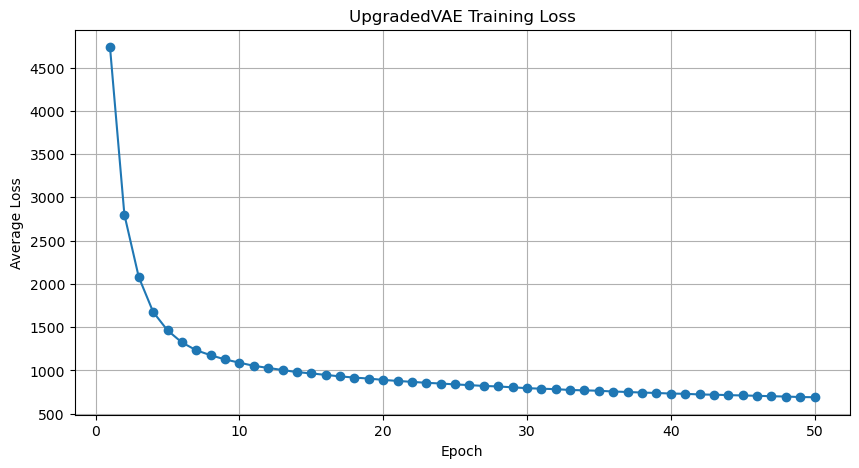

In [28]:
# 设置训练的总周期数
epochs = 50 # 对于更复杂的模型和数据集，可能需要更多的 epochs 才能看到好的结果

# 创建一个列表来存储每个 epoch 的损失，方便后续绘图
training_losses = []

print("Starting training for the UpgradedVAE model...")

# 循环指定的周期数
for epoch in range(1, epochs + 1):
    epoch_loss = train_epoch(
        epoch=epoch,
        model=upgraded_model,
        dataloader=train_loader,
        optimizer=optimizer,
        device=device
    )
    training_losses.append(epoch_loss)

print("\nTraining finished!")

# (可选) 绘制损失曲线
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_losses, marker='o', linestyle='-')
plt.title("UpgradedVAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

Let's generate some images:

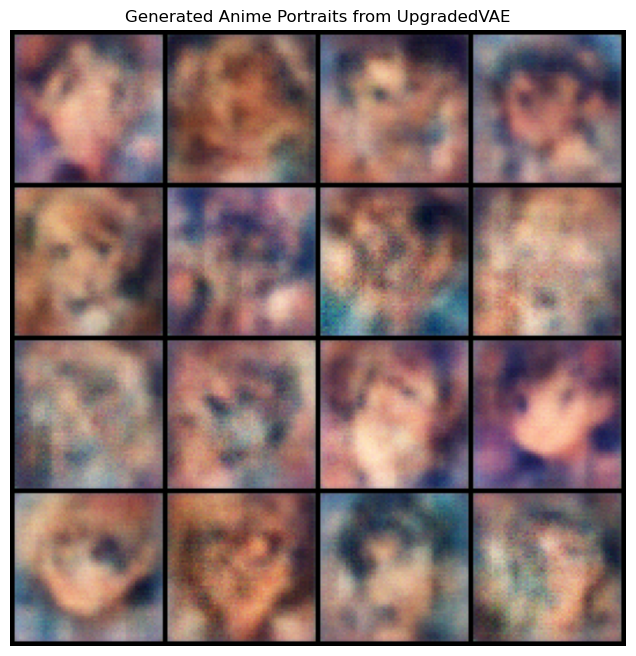

In [24]:
import torchvision
import matplotlib.pyplot as plt

# 确保你的加强版模型（upgraded_model）和设备（device）已经定义并加载了训练好的权重

# 1. 将模型设置为评估模式 (Evaluation Mode)
# 这很重要，因为它会关闭 BatchNorm 和 Dropout 等在训练和推理时行为不同的层
upgraded_model.eval()

# 2. 定义要生成的图像数量
num_images_to_generate = 16 # 我们来生成一个 4x4 的网格

# 3. 从标准正态分布中随机采样潜在向量 z
# latent_dim 应该与你训练模型时使用的维度一致 (这里是 256)
# 使用 torch.randn 来生成均值为0，方差为1的随机数
with torch.no_grad(): # 在这个块中，我们不需要计算梯度
    # 创建随机的潜在向量 z，形状为 (生成数量, latent_dim)
    z = torch.randn(num_images_to_generate, latent_dim).to(device)
    
    # 4. 使用解码器生成新图像
    # 我们只调用模型的解码器部分。
    # 为了方便，我们可以直接把 z 通过整个生成流程，因为我们不会用到重建损失
    # 我们需要先将z通过解码器的全连接层，然后 un-flatten，再通过卷积解码器
    generated_images = upgraded_model.decoder_fc(z)
    generated_images = generated_images.view(-1, 512, 4, 4) # Reshape to match decoder input
    generated_images = upgraded_model.decoder(generated_images)

# 5. 将生成的图像排列成网格并显示
# 将张量移动到CPU
generated_images = generated_images.cpu()

# 使用 make_grid 创建一个图像网格
# normalize=True 会自动将图像的 [-1, 1] 范围转换回 [0, 1] 以便显示
grid = torchvision.utils.make_grid(generated_images, nrow=4, normalize=True)

# 将张量从 (C, H, W) 转换为 (H, W, C) 以便 matplotlib 显示
grid_np = grid.permute(1, 2, 0).numpy()

# 显示图像
plt.figure(figsize=(8, 8))
plt.imshow(grid_np)
plt.axis('off')
plt.title('Generated Anime Portraits from UpgradedVAE')
plt.show()

The quality of generated images heavily depends on the model architecture, latent dimension size, dataset complexity, and training duration. These might not look perfect after a short training run.

## **🔹 Exercise: Effect of Latent Dimension and Beta Parameter**

### **📝 Tasks**
1. **Latent Dimension**: Try different `latent_dim` values (32, 64, 256, 512) - observe the trade-off between compression and quality
2. **Beta Parameter**: Experiment with different `beta` values (0.1, 0.5, 2.0, 10.0) - controls the balance between reconstruction and regularization
3. **Architecture**: Try adding/removing layers or changing filter sizes

### **🎯 Key Observations to Make**
- **Lower latent_dim**: More compression but potentially blurrier results
- **Higher beta**: More regularized latent space but potentially worse reconstruction
- **Lower beta**: Better reconstruction but potentially less structured latent space
